# Bankruptcy Predictions with Gradient Boosting Ensemble Models

#### Import libraries


In [4]:
# Library for Data Handling
import pandas as pd

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for data split and model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Library for Resampling Training Data
from imblearn.over_sampling import RandomOverSampler

# Library for creating Pipeline
from sklearn.pipeline import make_pipeline

# Library for Imputing Missing values
from sklearn.impute import SimpleImputer

# Library for Model training
from sklearn.ensemble import GradientBoostingClassifier


# Library for Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
# Library for object Serialization
import pickle

In [5]:
# Read the cleaned csv to DataFrame
df = pd.read_csv('../data/cleaned_dataframe.csv', compression='zip',  index_col=0)
print(df.shape)
df.head()

(43405, 66)


,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,bankrupt
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,False
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,False
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,False
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,False
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,False


#### Train-test split

In [6]:
# Split the data into train and test set
target = 'bankrupt'
X = df.drop(target, axis=1)
y = df[target]

In [7]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 65)
y_train shape: (34724,)
X_test shape: (8681, 65)
y_test shape: (8681,)


#### Resample

While exploring the dataset, I noticed class imbalance on the target column, in order to balance the class distribution and remove bias towards the majority class, I'll perform Oversampling on the training set.

In [8]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
print("y_train_over shape:", y_train_over.shape)

X_train_over shape: (66148, 65)
y_train_over shape: (66148,)


In [9]:
X_train_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66148 entries, 0 to 66147
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    66148 non-null  int64  
 1   A1      66147 non-null  float64
 2   A2      66147 non-null  float64
 3   A3      66147 non-null  float64
 4   A4      65944 non-null  float64
 5   A5      66076 non-null  float64
 6   A6      66147 non-null  float64
 7   A7      66147 non-null  float64
 8   A8      65994 non-null  float64
 9   A9      66121 non-null  float64
 10  A10     66147 non-null  float64
 11  A11     65534 non-null  float64
 12  A12     65944 non-null  float64
 13  A13     65921 non-null  float64
 14  A14     66147 non-null  float64
 15  A15     66123 non-null  float64
 16  A16     65993 non-null  float64
 17  A17     65994 non-null  float64
 18  A18     66147 non-null  float64
 19  A19     65920 non-null  float64
 20  A20     65921 non-null  float64
 21  A21     52414 non-null  float64
 22

The info above show that there are missing values in our data, this will require introducing a transformer into the pipeline, I'll use `SimpleImputer()` in this case.

#### Build Model

##### Baseline Accuracy

In [10]:
# Calculate the Baseline Accuracy 
baseline_acc = y_train_over.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5


I'll create an instance of a pipeline with `make_pipeline`, including the `SimpleImputer` transformer and the `GradientBoostingClassifier` predictor.

In [11]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier(random_state=42))

In [12]:
parameters = {
    'simpleimputer__strategy': ['mean', 'median'],
    'GradientBoostingClassifier__max_depth'.lower(): range(2,5),
    'GradientBoostingClassifier__n_estimators'.lower(): range(20, 31, 5)
}
parameters

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__max_depth': range(2, 5),
 'gradientboostingclassifier__n_estimators': range(20, 31, 5)}

In [13]:
model = GridSearchCV(estimator=clf, cv=5, param_grid=parameters, verbose=1, n_jobs=-1)

In [14]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [15]:
# Extract the best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'median'}

#### Evaluating the model performance

##### Accuracy score

In [16]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8778
Validation Accuracy: 0.8665


##### Confusion Matrix

I'll use a confusion matrix to see how the model is making it's predictions 

In [17]:
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[7162, 1078],
       [  81,  360]], dtype=int64)

Plotting it to aid proper visualization

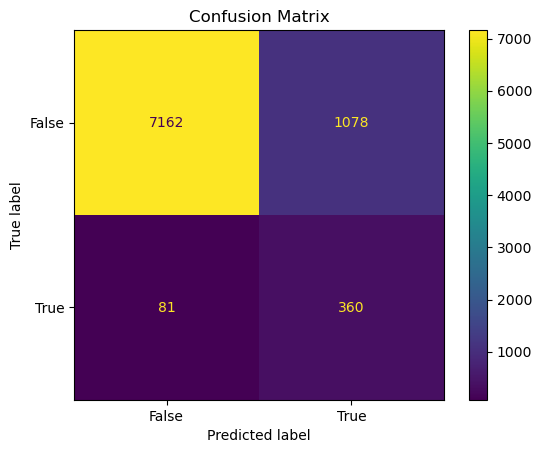

In [18]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix');

The Displayed confusion matrix serves as a reminder of how imbalanced our data is and why **Accuracy** is not always the best for judging if a model is giving us what we want.

Due to the class imbalance, if over 90% of the companies did not go bankrupt, our model will always predict `bankrupt` as `False`, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

**Precision** and **Recall** are more preferred in this cases.

In [19]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      8240
        True       0.25      0.82      0.38       441

    accuracy                           0.87      8681
   macro avg       0.62      0.84      0.65      8681
weighted avg       0.95      0.87      0.90      8681



For the purpose of this model, I am focusing on the performance of the classifier in the Positive class i.e `True` class, where a company is predicted to go bankrupt. Hence i'll be using the 'True' row from the above classification report

##### Precision-Recall Curve

Precision-Recall Curve is a performance measure for binary classification. It's used when there is an imbalance between the positive and negative classes, or when the focus is on the performance of the classifier in the positive class like in this case.

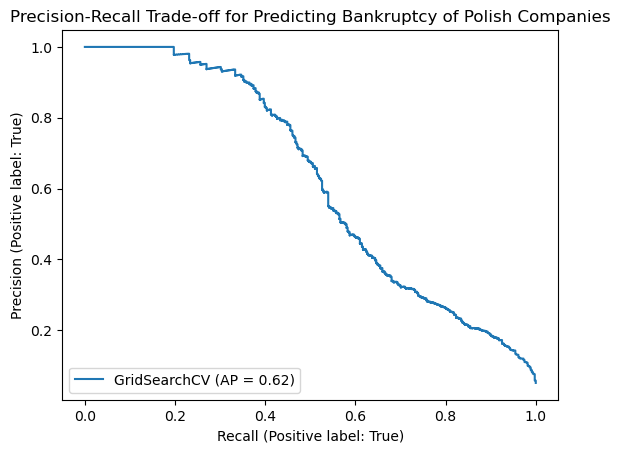

In [20]:
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title("Precision-Recall Trade-off for Predicting Bankruptcy of Polish Companies");

In this specific chart, the precision starts high and decreases as recall increases. This is a typical behavior because if I lower the threshold to predict positive classes, it will result to more true positives **(increasing recall)**, but also more false positives **(decreasing precision)**.

An Average Precision(AP) of **0.62** represents average precision of the model for all thresholds.

### Communicate Result

I'll create a histogram to show the 10 most important features for the model's predictions.

Text(0.5, 1.0, 'Feature Importance')

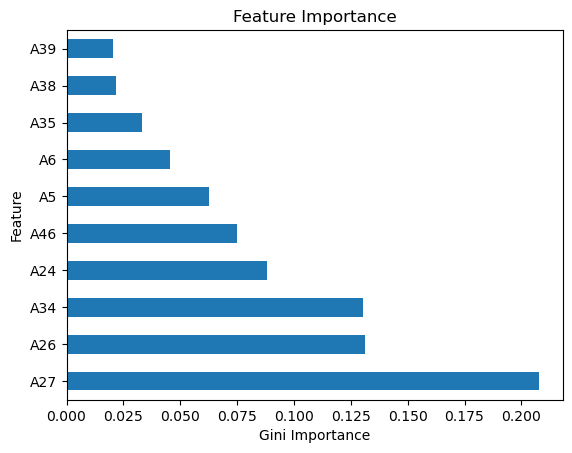

In [21]:
features = X_train_over.columns
importance = model.best_estimator_.named_steps['gradientboostingclassifier'].feature_importances_

feat_imp = pd.Series(index=features, data=importance).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title('Feature Importance')

#### Model Serialization 

In [22]:
# Save the best model
with open('company-bankruptcy-classifier.pkl', 'wb') as f:
    pickle.dump(model, f)